In [2]:
import pandas as pd
import numpy as np
import cv2
import os
import gc
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from keras.utils import to_categorical
from keras.models import Sequential
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from keras.optimizers import Adam

In [3]:

# Load the datasets
labels_df = pd.read_csv('Data/input/classification_labels.csv')
ancestors_df = pd.read_csv('Data/input/name_to_ancestors.csv')

# Define the directory containing the images
image_dir = 'Data/input/images'  # Adjust this path as needed

# Construct full image paths
labels_df['image_path'] = labels_df['basename'].apply(lambda x: os.path.join(image_dir, f"{x}.jpg"))

In [4]:
# Preprocessing function
def preprocess_images(image_paths):
    images = []
    for path in image_paths:
        image = cv2.imread(path)
        if image is not None:
            image = cv2.resize(image, (128, 128))  # Resize to a fixed size
            images.append(image)
        else:
            print(f"Warning: Unable to read image at {path}")
    images = np.array(images)
    images = images / 255.0  # Normalize the images
    return images

# Load and preprocess the images
image_paths = labels_df['image_path'].values
images = preprocess_images(image_paths)

# Encode the labels
label_encoder = LabelEncoder()
labels = label_encoder.fit_transform(labels_df['deepest_name'])
labels = to_categorical(labels)

print(f"Preprocessing complete for {len(images)} images.")

Preprocessing complete for 39445 images.


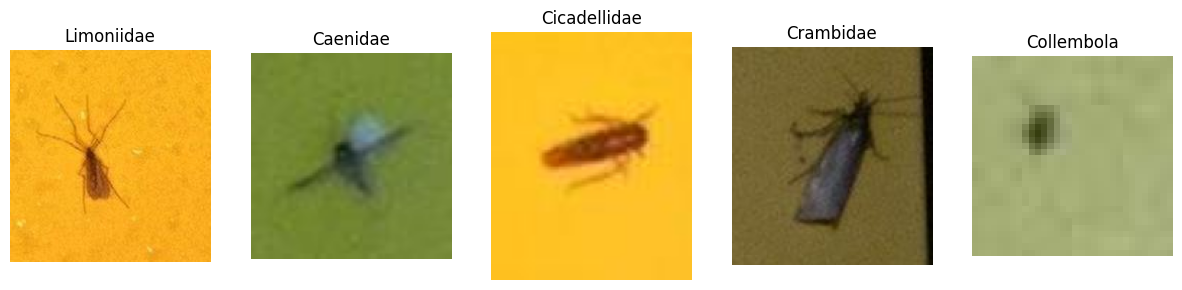

In [5]:
import matplotlib.pyplot as plt

# Function to display images with their labels
def display_sample_images(image_paths, labels, num_samples=5):
    plt.figure(figsize=(15, 10))
    for i in range(num_samples):
        img = cv2.imread(image_paths[i])
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        plt.subplot(1, num_samples, i+1)
        plt.imshow(img)
        plt.title(labels[i])
        plt.axis('off')
    plt.show()

# Get the first few image paths and their corresponding labels
sample_image_paths = labels_df['image_path'].values[:5]
sample_labels = labels_df['deepest_name'].values[:5]

# Display the sample images
display_sample_images(sample_image_paths, sample_labels)

In [6]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(images, labels, test_size=0.2, random_state=42)

# Build a simple CNN model
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(128, 128, 3)),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(len(np.unique(labels_df['deepest_name'])), activation='softmax')
])

In [7]:
# Compile the model
model.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])

# Maak de ImageDataGenerator aan voor augmentatie en rescaling
datagen = ImageDataGenerator(
    rescale=1./255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    validation_split=0.2  # Splitsing voor training en validatie
)

# Laad de training data met behulp van de generator
train_generator = datagen.flow_from_dataframe(
    dataframe=labels_df,
    directory='Data/input/images',  # Pad naar de map met afbeeldingen
    x_col='basename',  # Kolom in DataFrame met bestandsnamen
    y_col='deepest_name',  # Kolom in DataFrame met labels
    subset="training",
    batch_size=32,  # Pas dit aan op basis van je geheugencapaciteit
    shuffle=True,
    class_mode="categorical",
    target_size=(128, 128)  # Resolutie van de afbeeldingen
)

# Laad de validatie data met behulp van de generator
validation_generator = datagen.flow_from_dataframe(
    dataframe=labels_df,
    directory='Data/input/images',
    x_col='basename',
    y_col='deepest_name',
    subset="validation",
    batch_size=32,
    shuffle=True,
    class_mode="categorical",
    target_size=(128, 128)
)

# Fit the model with EarlyStopping
history = model.fit(
    X_train, y_train,
    epochs=10,  
    batch_size=32,
    validation_data=(X_test, y_test)
)

Found 0 validated image filenames belonging to 0 classes.
Found 0 validated image filenames belonging to 0 classes.


c:\Users\Gebruiker\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\preprocessing\image.py:1137: UserWarning: Found 39445 invalid image filename(s) in x_col="basename". These filename(s) will be ignored.
  warnings.warn(
c:\Users\Gebruiker\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\preprocessing\image.py:1137: UserWarning: Found 39445 invalid image filename(s) in x_col="basename". These filename(s) will be ignored.
  warnings.warn(


KeyboardInterrupt: 

In [ ]:
# Save predictions to CSV
predictions = model.predict(X_test)
predicted_labels = label_encoder.inverse_transform(np.argmax(predictions, axis=1))
output_df = pd.DataFrame({'image_path': image_paths[:len(X_test)], 'predicted_species': predicted_labels})
output_df.to_csv('Data/output/predictions.csv', index=False)